In [6]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [7]:
#load and preprocess the data
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


/var/folders/tg/g161x0m50lxgx68hfwk_3qk80000gn/T/ipykernel_68878/614486355.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby('region')['charges'].agg(['mean', 'count', 'std'])


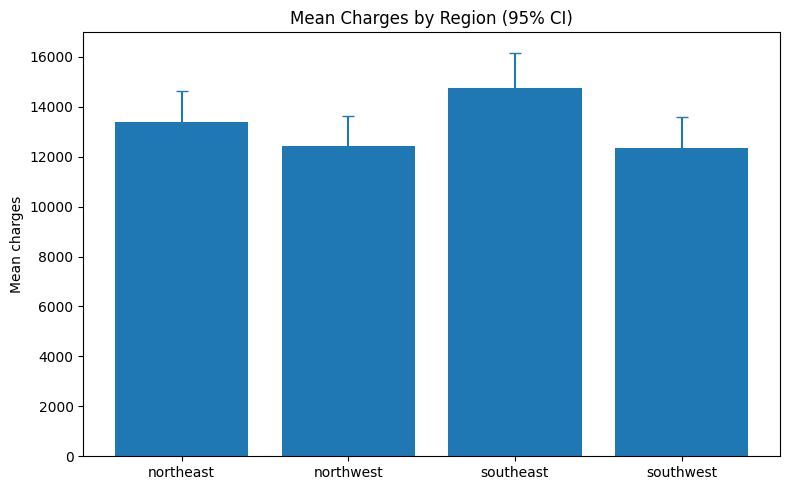

In [8]:
df['region'] = df['region'].astype('category')
df['log_charges'] = np.log1p(df['charges'])

agg = df.groupby('region')['charges'].agg(['mean', 'count', 'std'])
agg['sem'] = agg['std'] / np.sqrt(agg['count'])
agg['ci95'] = 1.96 * agg['sem']        # ~95% CI

regions = agg.index.astype(str).tolist()
y = agg['mean'].to_numpy()
yerr = agg['ci95'].to_numpy()

x = np.arange(len(regions))

plt.figure(figsize=(8,5))
plt.bar(x, y)
plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, regions)
plt.ylabel("Mean charges")
plt.title("Mean Charges by Region (95% CI)")
plt.tight_layout()
plt.show()


/var/folders/tg/g161x0m50lxgx68hfwk_3qk80000gn/T/ipykernel_68878/3666973773.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_log = df.groupby('region')['log_charges'].agg(['mean', 'count', 'std'])


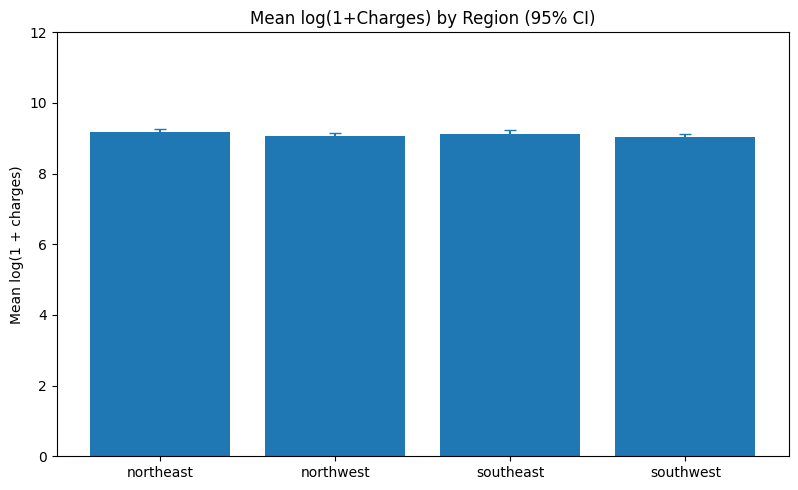

In [9]:
agg_log = df.groupby('region')['log_charges'].agg(['mean', 'count', 'std'])
agg_log['sem']  = agg_log['std'] / np.sqrt(agg_log['count'])
agg_log['ci95'] = 1.96 * agg_log['sem']

regions = agg_log.index.astype(str).tolist()
y = agg_log['mean'].to_numpy()
yerr = agg_log['ci95'].to_numpy()

x = np.arange(len(regions))

plt.figure(figsize=(8,5))
plt.bar(x, y)
plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=4)
plt.xticks(x, regions)
plt.ylabel("Mean log(1 + charges)")
plt.title("Mean log(1+Charges) by Region (95% CI)")
plt.tight_layout()
plt.ylim(0, 12)     # charges in dollars
plt.show()

/var/folders/tg/g161x0m50lxgx68hfwk_3qk80000gn/T/ipykernel_68878/2302219080.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([female, male], labels=['Female', 'Male'], showfliers=True)  # set showfliers=False to hide outliers


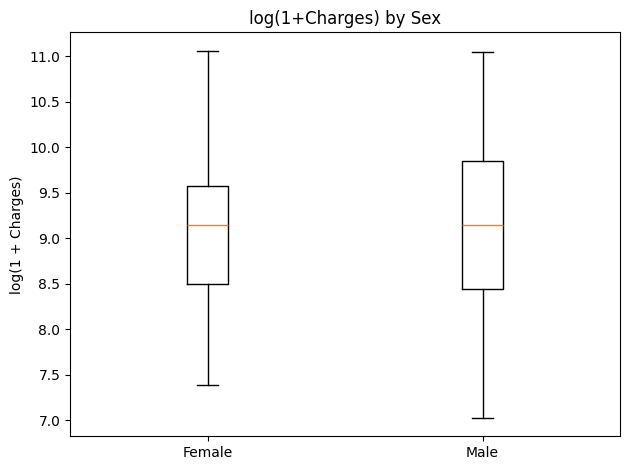

In [10]:
# 1) Create a log-transformed column (handles zero safely)
#    log(1 + x) so there’s no issue if any charge == 0

# (Optional) sanity check for negatives
assert (df['charges'] >= 0).all(), "Found negative charges; log1p is undefined there."

# 2) Ensure categorical for clean grouping
df['sex'] = df['sex'].astype('category')

# 3) Side-by-side boxplot of log-transformed charges by sex
female = df.loc[df['sex'].str.lower() == 'female', 'log_charges'].values
male   = df.loc[df['sex'].str.lower() == 'male',   'log_charges'].values

plt.figure()
plt.boxplot([female, male], labels=['Female', 'Male'], showfliers=True)  # set showfliers=False to hide outliers
plt.ylabel('log(1 + Charges)')
plt.title('log(1+Charges) by Sex')
plt.tight_layout()
plt.show()

In [11]:
df.dtypes

age               int64
sex            category
bmi             float64
children          int64
smoker           object
region         category
charges         float64
log_charges     float64
dtype: object

          count          mean           std        min          25%  \
children                                                              
0         574.0  12365.975602  12023.293942  1121.8739  2734.421150   
1         324.0  12731.171832  11823.631451  1711.0268  4791.643175   
2         240.0  15073.563734  12891.368347  2304.0022  6284.939438   
3         157.0  15355.318367  12330.869484  3443.0640  6652.528800   
4          25.0  13850.656311   9139.223321  4504.6624  7512.267000   
5          18.0   8786.035247   3808.435525  4687.7970  5874.973900   

                  50%           75%          max  
children                                          
0          9856.95190  14440.123825  63770.42801  
1          8483.87015  15632.052050  58571.07448  
2          9264.97915  20379.276748  49577.66240  
3         10600.54830  19199.944000  60021.39897  
4         11033.66170  17128.426080  40182.24600  
5          8589.56505  10019.943975  19023.26000  


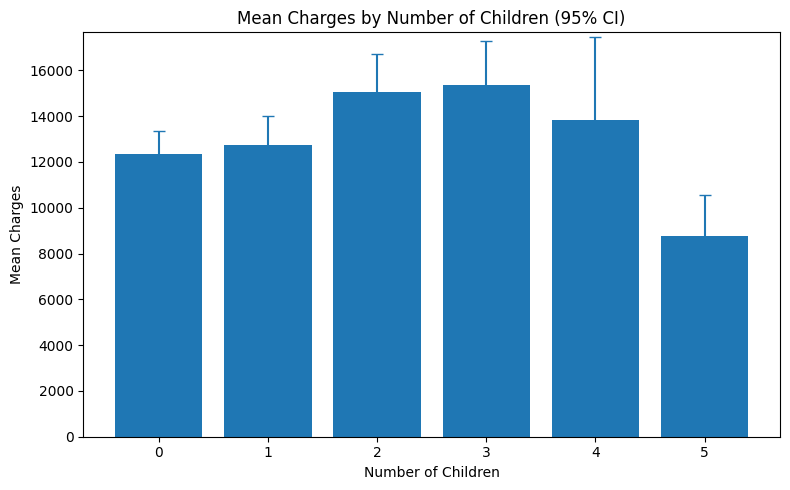

In [12]:
by_kids = df.groupby('children')['charges'].describe()
print(by_kids)

# -------- 2) Mean charges bar chart (+ 95% CI) --------
agg = df.groupby('children')['charges'].agg(['mean', 'count', 'std'])
agg['sem']  = agg['std'] / np.sqrt(agg['count'])
agg['ci95'] = 1.96 * agg['sem']  # ~95% CI

kids = agg.index.to_numpy()
y    = agg['mean'].to_numpy()
yerr = agg['ci95'].to_numpy()

plt.figure(figsize=(8,5))
plt.bar(kids, y)
plt.errorbar(kids, y, yerr=yerr, fmt='none', capsize=4)
plt.xlabel("Number of Children")
plt.ylabel("Mean Charges")
plt.title("Mean Charges by Number of Children (95% CI)")
plt.xticks(kids)
plt.ylim(0, y.max()*1.15)
plt.tight_layout()
plt.show()


# Feature Engineering

In [13]:
# Ensure smoker is binary (1=yes, 0=no)
df["smoker_bin"] = df["smoker"].map({"yes": 1, "no": 0}).astype(int)

# --- Interaction features ---
df["bmi_x_smoker"] = df["bmi"] * df["smoker_bin"]
df["age_x_smoker"] = df["age"] * df["smoker_bin"]

# --- Nonlinear interaction: smoker AND high BMI (binary & piecewise-linear) ---
df["smoker_obese"] = ((df["smoker_bin"] == 1) & (df["bmi"] > 30)).astype(int)
df["bmi_excess_30"] = np.maximum(df["bmi"] - 30, 0.0)
df["bmi_excess_30_x_smoker"] = df["bmi_excess_30"] * df["smoker_bin"]
# keep main effects: bmi, smoker_bin, and bmi_x_smoker

# (optional) keep everything tidy
feature_cols = ["age","bmi","children","smoker_bin","bmi_x_smoker","age_x_smoker","bmi_excess_30","bmi_excess_30_x_smoker","charges"]
df[feature_cols].head()

,age,bmi,children,smoker_bin,bmi_x_smoker,age_x_smoker,bmi_excess_30,bmi_excess_30_x_smoker,charges
0,19,27.900,0,1,27.9,19,0.00,0.0,16884.92400
1,18,33.770,1,0,0.0,0,3.77,0.0,1725.55230
2,28,33.000,3,0,0.0,0,3.00,0.0,4449.46200
3,33,22.705,0,0,0.0,0,0.00,0.0,21984.47061
4,32,28.880,0,0,0.0,0,0.00,0.0,3866.85520


In [14]:
X = df[["age","bmi","children","smoker_bin","bmi_x_smoker","age_x_smoker","smoker_obese","bmi_excess_30","bmi_excess_30_x_smoker"]]
y = df["charges"]

# Linear Regression Models

[OLS] RMSE: 5,002.63 | R²: 0.8467


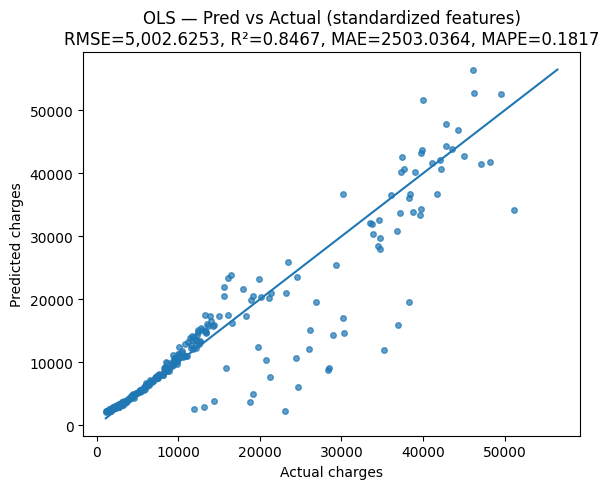

[Ridge] RMSE: 5,013.83 | R²: 0.8460
  alpha_ = 1.7783


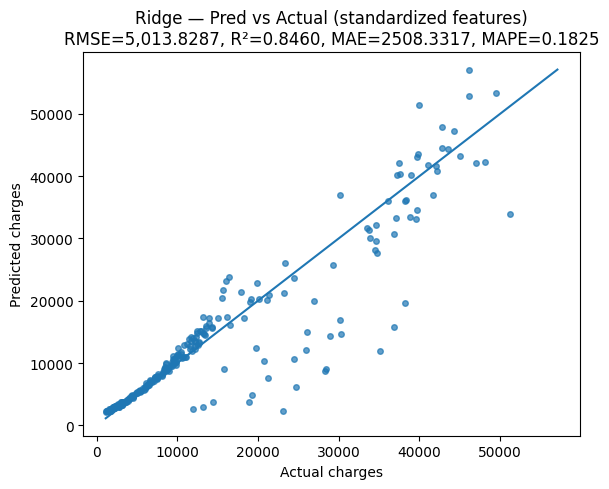

[Lasso] RMSE: 5,001.72 | R²: 0.8468
  alpha_ = 0.0001


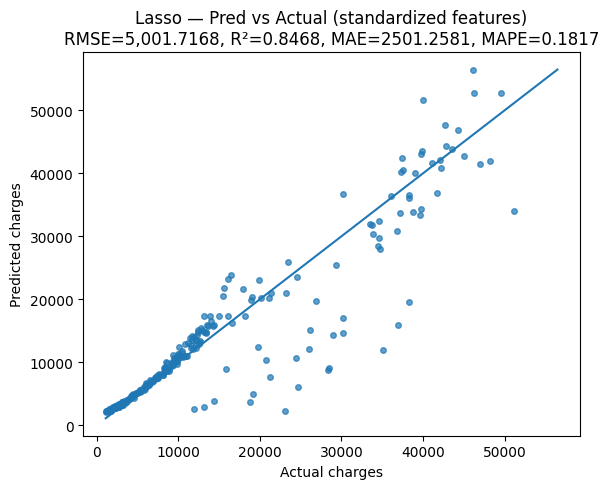

[ElasticNet] RMSE: 5,010.90 | R²: 0.8462
  alpha_ = 0.0016
  l1_ratio_ = 0.1500


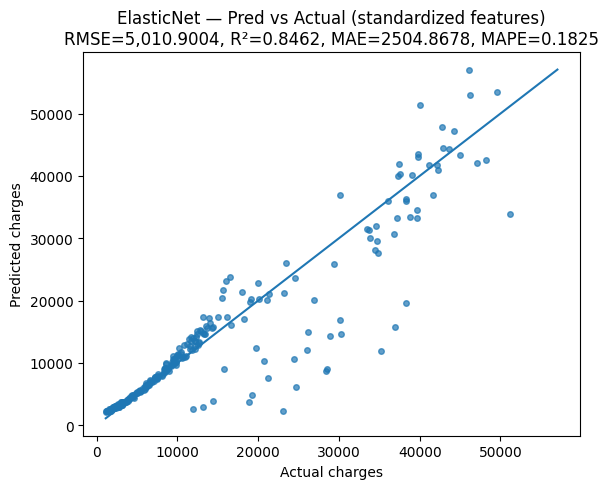

In [15]:
# --- CONFIG ---
USE_LOG_TARGET = True
features = ['age', 'bmi', 'sex', 'smoker', 'region', 'children', 'bmi_x_smoker', 'age_x_smoker', 
            'smoker_obese', 'bmi_excess_30', 'bmi_excess_30_x_smoker']
target   = 'charges'

X = df[features].copy()
y = np.log(df[target]) if USE_LOG_TARGET else df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

num_cols = ['age', 'bmi', 'children', 'bmi_x_smoker', 'age_x_smoker', 'bmi_excess_30', 'bmi_excess_30_x_smoker']
cat_cols = ['sex', 'smoker', 'region', 'smoker_obese']

# ✅ Preprocess: scale numeric + one-hot categorical
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ("scale", StandardScaler(with_mean=False))  # scale one-hot columns too
        ]), cat_cols)
    ]
)

# --- Models ---
ols = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5)
lasso = LassoCV(alphas=np.logspace(-4, 1, 30), cv=5, max_iter=10000, n_jobs=-1, random_state=88)
enet  = ElasticNetCV(l1_ratio=[0.15, 0.3, 0.5, 0.7, 0.85, 1.0],
                     alphas=np.logspace(-4, 1, 30), cv=5, max_iter=20000, n_jobs=-1, random_state=88)

models = {"OLS": ols, "Ridge": ridge, "Lasso": lasso, "ElasticNet": enet}

def eval_and_plot(name, model):
    pipe = Pipeline([
        ("prep", pre),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    if USE_LOG_TARGET:
        y_true_plot = np.expm1(y_test)
        y_pred_plot = np.expm1(y_pred)
    else:
        y_true_plot = y_test
        y_pred_plot = y_pred

    mse = mean_squared_error(y_true_plot, y_pred_plot)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_plot, y_pred_plot)
    mape = mean_absolute_percentage_error(y_true_plot, y_pred_plot)
    r2   = r2_score(y_true_plot, y_pred_plot)

    print(f"[{name}] RMSE: {rmse:,.2f} | R²: {r2:.4f}")
    if hasattr(model, "alpha_"):
        print(f"  alpha_ = {model.alpha_:.4f}")
    if hasattr(model, "l1_ratio_"):
        print(f"  l1_ratio_ = {model.l1_ratio_:.4f}")

    plt.figure(figsize=(6,5))
    plt.scatter(y_true_plot, y_pred_plot, s=16, alpha=0.7)
    lo, hi = float(min(y_true_plot.min(), y_pred_plot.min())), float(max(y_true_plot.max(), y_pred_plot.max()))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual charges")
    plt.ylabel("Predicted charges")
    plt.title(f"{name} — Pred vs Actual (standardized features)\nRMSE={rmse:,.4f}, R²={r2:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}")
    plt.tight_layout()
    plt.show()

for name, mdl in models.items():
    eval_and_plot(name, mdl)

[Ridge] alpha_ = 1.77828
[Lasso] alpha_ = 0.000148735
[ElasticNet] alpha_ = 0.00161026
[ElasticNet] l1_ratio_ = 0.150
[OLS] RMSE: 5,324.14 | MAE: 3,301.43 | MAPE: 0.2831 | R²: 0.8264


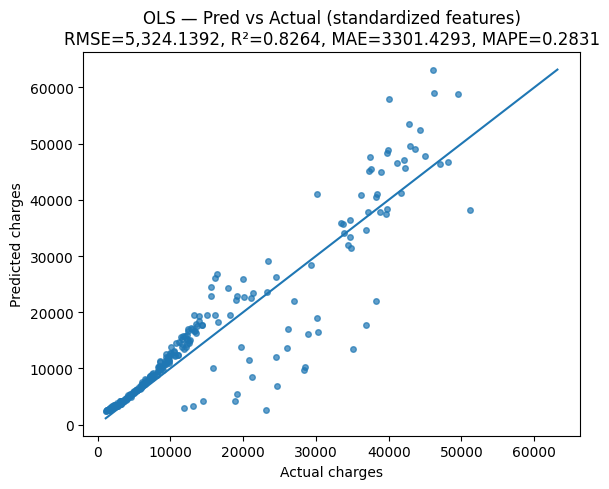

[Ridge] RMSE: 5,330.30 | MAE: 3,285.08 | MAPE: 0.2831 | R²: 0.8260


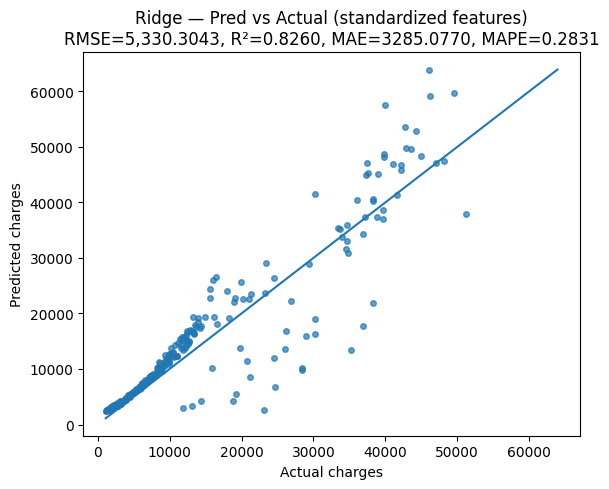

[Lasso] RMSE: 5,319.42 | MAE: 3,294.01 | MAPE: 0.2830 | R²: 0.8267


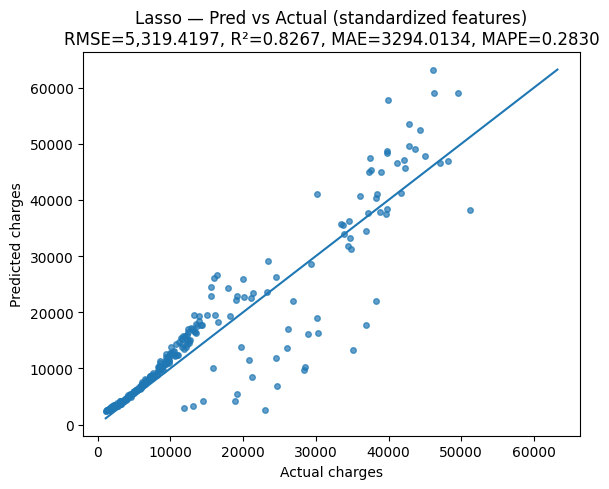

[ElasticNet] RMSE: 5,322.36 | MAE: 3,278.11 | MAPE: 0.2830 | R²: 0.8265


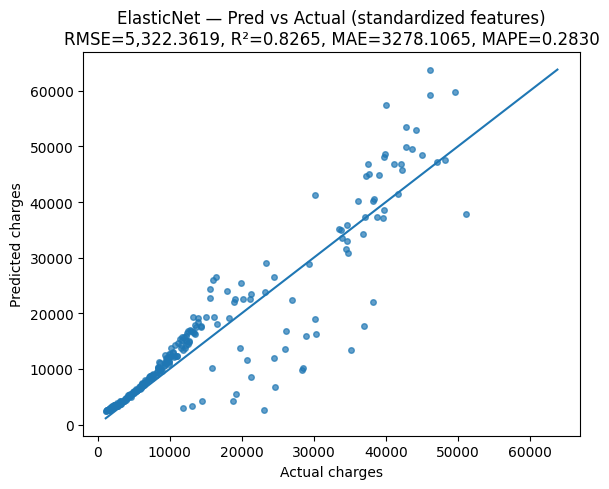

In [16]:
# --- CONFIG ---
USE_LOG_TARGET = True
features = ['age', 'bmi', 'sex', 'smoker', 'region', 'children', 'bmi_x_smoker', 'age_x_smoker', 
            'smoker_obese', 'bmi_excess_30', 'bmi_excess_30_x_smoker']
target   = 'charges'

X = df[features].copy()
y = np.log(df[target]) if USE_LOG_TARGET else df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

num_cols = ['age', 'bmi', 'children', 'bmi_x_smoker', 'age_x_smoker', 'bmi_excess_30', 'bmi_excess_30_x_smoker']
cat_cols = ['sex', 'smoker', 'region', 'smoker_obese']

# ✅ Preprocess: scale numeric + one-hot categorical
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ("scale", StandardScaler(with_mean=False))  # scale one-hot columns too
        ]), cat_cols)
    ]
)

# --- Models ---
ols = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5)
lasso = LassoCV(alphas=np.logspace(-4, 1, 30), cv=5, max_iter=10000, n_jobs=-1, random_state=88)
enet  = ElasticNetCV(l1_ratio=[0.15, 0.3, 0.5, 0.7, 0.85, 1.0],
                     alphas=np.logspace(-4, 1, 30), cv=5, max_iter=20000, n_jobs=-1, random_state=88)

models = {"OLS": ols, "Ridge": ridge, "Lasso": lasso, "ElasticNet": enet}

def fit_with_smearing(name, model, preprocessor, X_train, y_train):
    """Fit pipeline and compute Duan smearing factor on the training set."""
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)

    # In-sample residuals in log-space
    yhat_tr_log = pipe.predict(X_train)
    resid_log   = y_train - yhat_tr_log

    # Duan smearing factor c = mean(exp(residual))
    smear_c = float(np.mean(np.exp(resid_log)))

    return pipe, smear_c

# Fit all models once and store (pipeline, smearing factor)
fitted = {}
for name, mdl in models.items():
    pipe, c = fit_with_smearing(name, mdl, pre, X_train, y_train)
    fitted[name] = {"pipe": pipe, "c": c}
    # Optional: peek at chosen alpha/l1_ratio
    m = pipe.named_steps["model"]
    if hasattr(m, "alpha_"):
        print(f"[{name}] alpha_ = {m.alpha_:.6g}")
    if hasattr(m, "l1_ratio_"):
        print(f"[{name}] l1_ratio_ = {m.l1_ratio_:.3f}")

def eval_and_plot_with_smearing(name, stored):
    pipe = stored["pipe"]
    c    = stored["c"]

    # Predict on test in log-space
    y_pred_log = pipe.predict(X_test)

    # Back-transform to charges using Duan smearing
    y_pred_chg = np.exp(y_pred_log) * c
    y_true_chg = np.exp(y_test)     # because y = log(charges)

    # Metrics on original scale
    mse  = mean_squared_error(y_true_chg, y_pred_chg)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true_chg, y_pred_chg)
    mape = mean_absolute_percentage_error(y_true_chg, y_pred_chg)
    r2   = r2_score(y_true_chg, y_pred_chg)

    print(f"[{name}] RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | MAPE: {mape:.4f} | R²: {r2:.4f}")

    # Plot Pred vs Actual on original charges
    plt.figure(figsize=(6,5))
    plt.scatter(y_true_chg, y_pred_chg, s=16, alpha=0.7)
    lo, hi = float(min(y_true_chg.min(), y_pred_chg.min())), float(max(y_true_chg.max(), y_pred_chg.max()))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual charges")
    plt.ylabel("Predicted charges")
    plt.title(f"{name} — Pred vs Actual (standardized features)\nRMSE={rmse:,.4f}, R²={r2:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}")
    plt.tight_layout()
    plt.show()

for name in models.keys():
    eval_and_plot_with_smearing(name, fitted[name])

[Ridge] alpha_ = 1.77828
[Lasso] alpha_ = 0.000148735
[ElasticNet] alpha_ = 0.00161026
[ElasticNet] l1_ratio_ = 0.150


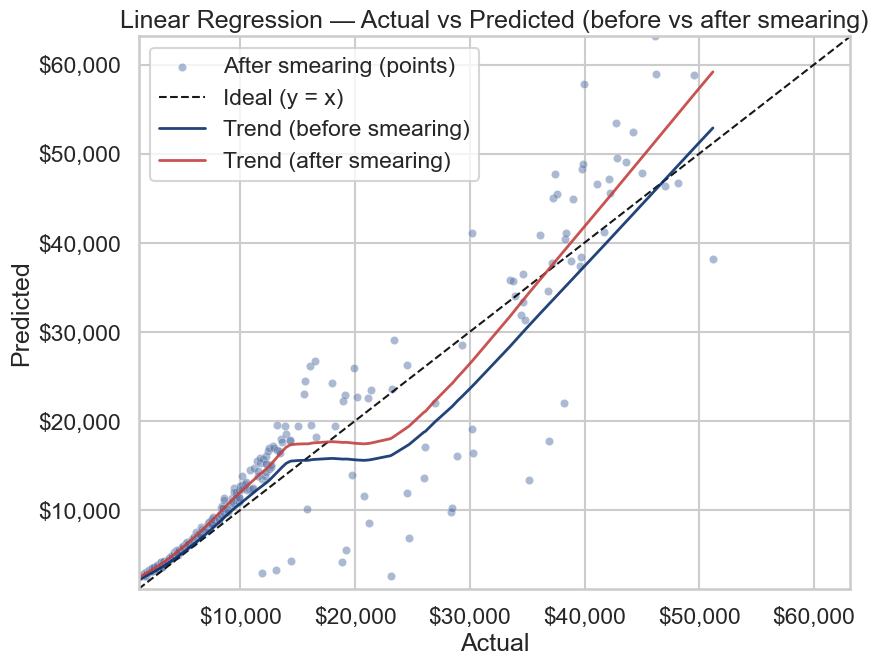

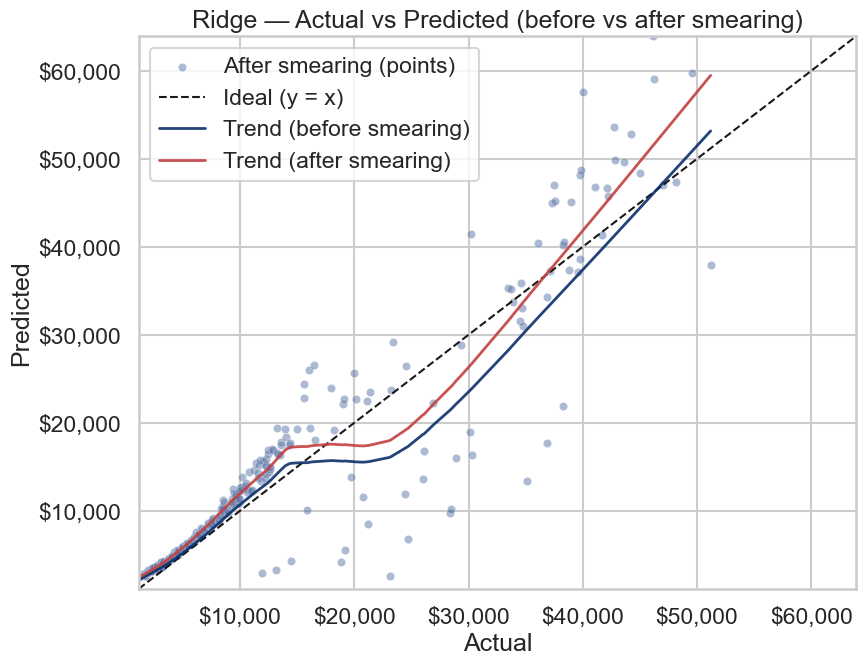

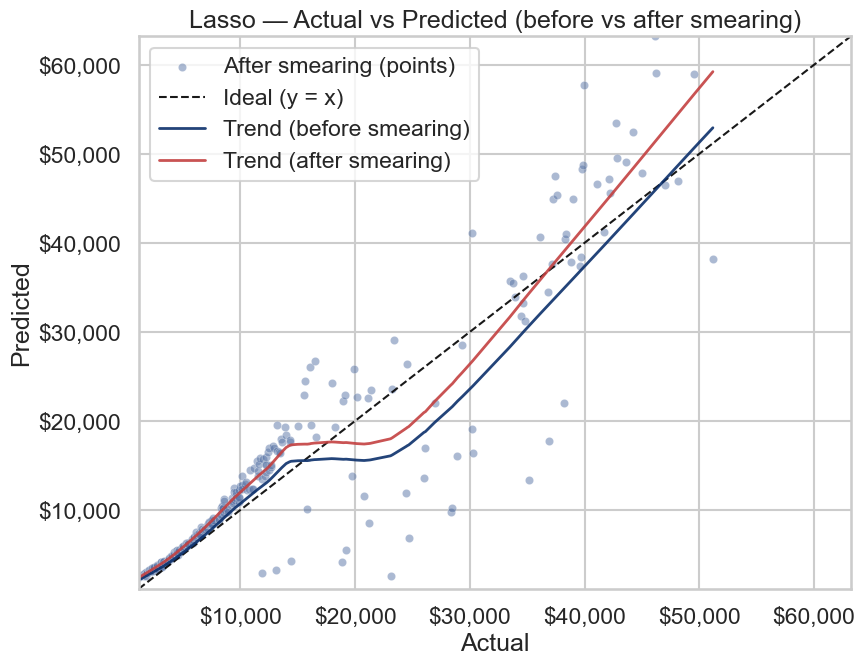

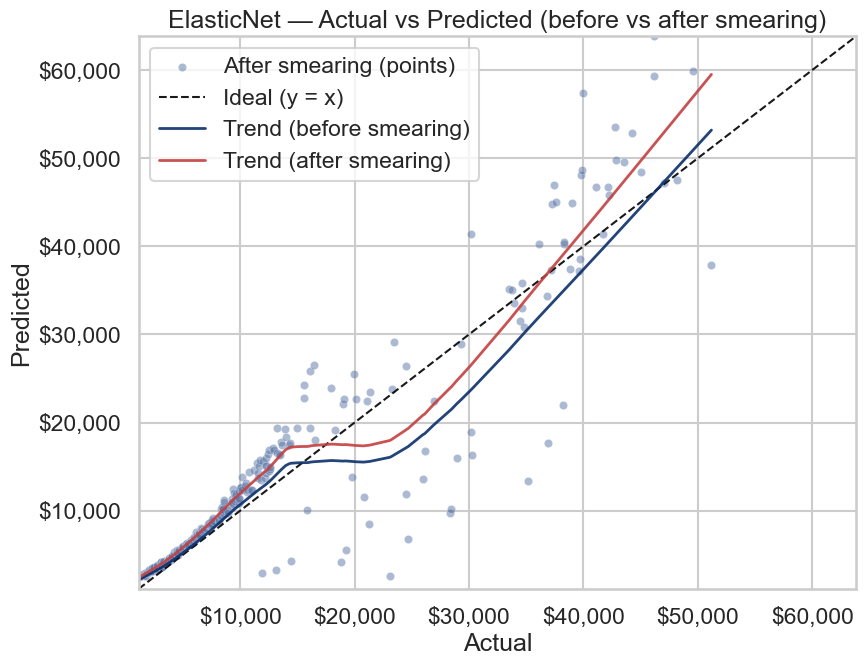


=== Metrics Before vs After Smearing (lower is better for RMSE/MAE/MAPE) ===
                   RMSE_before  RMSE_after  MAE_before  MAE_after  MAPE_before  MAPE_after  R2_before  R2_after  Smearing_c
Model                                                                                                                      
Lasso                  5001.72     5319.42     2501.26    3294.01       0.1817      0.2830     0.8468    0.8267    1.119063
ElasticNet             5010.90     5322.36     2504.87    3278.11       0.1825      0.2830     0.8462    0.8265    1.118766
Linear Regression      5002.63     5324.14     2503.04    3301.43       0.1816      0.2831     0.8467    0.8264    1.119121
Ridge                  5013.83     5330.30     2508.33    3285.08       0.1824      0.2831     0.8460    0.8260    1.118793


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# --- CONFIG ---
USE_LOG_TARGET = True
features = ['age', 'bmi', 'sex', 'smoker', 'region', 'children',
            'bmi_x_smoker', 'age_x_smoker', 'smoker_obese', 'bmi_excess_30', 'bmi_excess_30_x_smoker']
target   = 'charges'

X = df[features].copy()
y = np.log(df[target]) if USE_LOG_TARGET else df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

num_cols = ['age', 'bmi', 'children', 'bmi_x_smoker', 'age_x_smoker', 'bmi_excess_30', 'bmi_excess_30_x_smoker']
cat_cols = ['sex', 'smoker', 'region', 'smoker_obese']

# ✅ Preprocess: scale numeric + one-hot categorical
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ("scale", StandardScaler(with_mean=False))  # scale one-hot columns too
        ]), cat_cols)
    ]
)

# --- Models ---
ols = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5)
lasso = LassoCV(alphas=np.logspace(-4, 1, 30), cv=5, max_iter=10000, n_jobs=-1, random_state=88)
enet  = ElasticNetCV(l1_ratio=[0.15, 0.3, 0.5, 0.7, 0.85, 1.0],
                     alphas=np.logspace(-4, 1, 30), cv=5, max_iter=20000, n_jobs=-1, random_state=88)

models = {"Linear Regression": ols, "Ridge": ridge, "Lasso": lasso, "ElasticNet": enet}

# ---- Utilities ----
_money_fmt = FuncFormatter(lambda x, _: f"${x:,.0f}")

def fit_with_smearing(name, model, preprocessor, X_train, y_train):
    """Fit pipeline and compute Duan smearing factor on the training set."""
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)

    # In-sample residuals in log-space
    yhat_tr_log = pipe.predict(X_train)
    resid_log   = y_train - yhat_tr_log

    # Duan smearing factor c = mean(exp(residual))
    smear_c = float(np.mean(np.exp(resid_log)))

    return pipe, smear_c

def parity_plot_dual(y_true, y_pred_before, y_pred_after, title,
                     metrics_before, metrics_after):
    import seaborn as sns
    from matplotlib.ticker import FuncFormatter

    vis_df = pd.DataFrame({
        "Actual":      np.asarray(y_true, dtype=float),
        "Pred_Before": np.asarray(y_pred_before, dtype=float),
        "Pred_After":  np.asarray(y_pred_after, dtype=float),
    }).sort_values("Actual")

    sns.set_theme(style="whitegrid", context="talk")
    fig, ax = plt.subplots(figsize=(9, 7))

    # Scatter (after-smearing points)
    sns.scatterplot(
        data=vis_df, x="Actual", y="Pred_After",
        ax=ax, alpha=0.5, s=35,
        edgecolor="white", linewidth=0.3,
        label="After smearing (points)",
        color="#5874A6"
    )

    # Identity line
    lo = float(min(vis_df["Actual"].min(), vis_df[["Pred_Before","Pred_After"]].min().min()))
    hi = float(max(vis_df["Actual"].max(), vis_df[["Pred_Before","Pred_After"]].max().max()))
    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1.5,
            color="black", alpha=0.9, label="Ideal (y = x)")
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    # --- helper: smooth trend (LOWESS if available, else quantile fallback) ---
    def _smooth_line(x, y, color, linestyle, label):
        try:
            from statsmodels.nonparametric.smoothers_lowess import lowess
            xy = lowess(y, x, frac=0.3, it=0, return_sorted=True)
            ax.plot(xy[:, 0], xy[:, 1], lw=2.0, alpha=0.9,
                    color=color, linestyle=linestyle, label=label)
        except Exception:
            tmp = pd.DataFrame({"x": x, "y": y}).sort_values("x")
            q = int(np.clip(len(tmp)//25, 15, 60))
            tmp["bin"] = pd.qcut(tmp["x"], q=q, duplicates="drop")
            agg = tmp.groupby("bin", observed=False).agg(x=("x","median"), y=("y","mean")).sort_values("x")
            ax.plot(agg["x"], agg["y"], lw=2.0, alpha=0.9,
                    color=color, linestyle=linestyle, label=label)

    # Trend lines — before & after smearing
    _smooth_line(vis_df["Actual"].values, vis_df["Pred_Before"].values,
                 color="#0B2F6B", linestyle="-", label="Trend (before smearing)")
    _smooth_line(vis_df["Actual"].values, vis_df["Pred_After"].values,
                 color="#C34040", linestyle="-", label="Trend (after smearing)")

    # Labels + style
    ax.set_title(title)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.legend(loc="upper left", frameon=True)
    money_fmt = FuncFormatter(lambda x, _: f"${x:,.0f}")
    ax.xaxis.set_major_formatter(money_fmt)
    ax.yaxis.set_major_formatter(money_fmt)

    plt.tight_layout()
    plt.show()

def eval_and_plot_with_smearing(name, stored):
    pipe = stored["pipe"]
    c    = stored["c"]

    # Predict on test in log-space
    y_pred_log = pipe.predict(X_test)

    # Back-transforms
    y_true_chg   = np.exp(y_test)          # because y = log(charges)
    y_pred_before = np.exp(y_pred_log)     # BEFORE smearing
    y_pred_after  = y_pred_before * c      # AFTER smearing

    # Metrics on original scale
    def _metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        return (
            np.sqrt(mse),                        # RMSE
            mean_absolute_error(y_true, y_pred), # MAE
            r2_score(y_true, y_pred)             # R²
        )

    rmse_b, mae_b, r2_b = _metrics(y_true_chg, y_pred_before)
    rmse_a, mae_a, r2_a = _metrics(y_true_chg, y_pred_after)

    # Parity plot with dual LOWESS lines
    parity_plot_dual(
        y_true=y_true_chg,
        y_pred_before=y_pred_before,
        y_pred_after=y_pred_after,
        title=f"{name} — Actual vs Predicted (before vs after smearing)",
        metrics_before=(rmse_b, mae_b, r2_b),
        metrics_after=(rmse_a, mae_a, r2_a),
    )

# ---- Fit all models once and store (pipeline, smearing factor) ----
fitted = {}
for name, mdl in models.items():
    pipe, c = fit_with_smearing(name, mdl, pre, X_train, y_train)
    fitted[name] = {"pipe": pipe, "c": c}
    # Optional: peek at chosen alpha/l1_ratio
    m = pipe.named_steps["model"]
    if hasattr(m, "alpha_"):
        print(f"[{name}] alpha_ = {m.alpha_:.6g}")
    if hasattr(m, "l1_ratio_"):
        print(f"[{name}] l1_ratio_ = {m.l1_ratio_:.3f}")

# ---- Evaluate + plot for each model ----
for name in models.keys():
    eval_and_plot_with_smearing(name, fitted[name])

# === Metrics table: before vs after smearing (no plots) ===
def metrics_table_before_after(fitted, X_test, y_test):
    y_true = np.exp(y_test)  # since y = log(charges)

    rows = []
    for name, obj in fitted.items():
        pipe, c = obj["pipe"], obj["c"]

        # predictions in log space -> raw charges
        y_pred_log     = pipe.predict(X_test)
        y_pred_before  = np.exp(y_pred_log)          # without smearing
        y_pred_after   = y_pred_before * c           # with Duan smearing

        def _metrics(yhat):
            return {
                "RMSE": np.sqrt(mean_squared_error(y_true, yhat)),
                "MAE":  mean_absolute_error(y_true, yhat),
                "MAPE": mean_absolute_percentage_error(y_true, yhat),
                "R2":   r2_score(y_true, yhat),
            }

        m_before = _metrics(y_pred_before)
        m_after  = _metrics(y_pred_after)

        rows.append({
            "Model": name,
            "RMSE_before": m_before["RMSE"],
            "RMSE_after":  m_after["RMSE"],
            "MAE_before":  m_before["MAE"],
            "MAE_after":   m_after["MAE"],
            "MAPE_before": m_before["MAPE"],
            "MAPE_after":  m_after["MAPE"],
            "R2_before":   m_before["R2"],
            "R2_after":    m_after["R2"],
            "Smearing_c":  float(c),
        })

    df_metrics = pd.DataFrame(rows).set_index("Model")
    # nice formatting (optional)
    fmt = df_metrics.copy()
    money_cols = ["RMSE_before","RMSE_after","MAE_before","MAE_after"]
    pct_cols   = ["MAPE_before","MAPE_after"]
    r2_cols    = ["R2_before","R2_after"]

    fmt[money_cols] = fmt[money_cols].round(2)
    fmt[pct_cols]   = fmt[pct_cols].round(4)
    fmt[r2_cols]    = fmt[r2_cols].round(4)
    fmt["Smearing_c"] = fmt["Smearing_c"].round(6)

    # sort by your preferred criterion (e.g., RMSE_after ascending)
    fmt = fmt.sort_values(by="RMSE_after", ascending=True)

    print("\n=== Metrics Before vs After Smearing (lower is better for RMSE/MAE/MAPE) ===")
    print(fmt.to_string())
    return df_metrics, fmt  # raw + formatted

# Usage:
raw_metrics, metrics_pretty = metrics_table_before_after(fitted, X_test, y_test)

# Sensitivity Analysis

In [18]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

# -----------------------------
# 1) Columns & target
# -----------------------------
num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]
target = "charges"
USE_LOG_TARGET = True

# df assumed loaded; ensure correct dtypes
# y as log(charges) is recommended
y = np.log(df[target]).values if USE_LOG_TARGET else df[target].values
X = df[num_cols + cat_cols].copy()

# -----------------------------
# 2) Your EXACT preprocessor
# -----------------------------
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ("scale",  StandardScaler(with_mean=False))  # scale OHE columns too
        ]), cat_cols)
    ]
)

# -----------------------------
# 3) Pipeline: preprocessor + ElasticNet
# -----------------------------
pipe = Pipeline([
    ("pre", pre),
    ("model", ElasticNet(l1_ratio=0.15, alpha=0.00048939, random_state=88))
])

pipe.fit(X, y)

# -----------------------------
# 4) Sensitivity on design matrix
#    (perturb 0.1 "scaled units" per feature)
# -----------------------------
# Get transformed matrix and feature names
Xt = pipe.named_steps["pre"].transform(X)

# Get names from the inner onehot
onehot = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = onehot.get_feature_names_out(cat_cols).tolist()
feat_names = num_cols + cat_feature_names

def sensitivity_over_matrix(model, X_mat, j, delta=0.1, on_dollars=False):
    """
    Mean absolute sensitivity per delta step for feature j.
    If on_dollars=True, computes % change on expm1 scale (approx).
    """
    X0 = X_mat
    X1 = X_mat.copy()
    X1[:, j] = X1[:, j] + delta

    y0 = model.predict(X0)
    y1 = model.predict(X1)

    if on_dollars:
        # Back-transform to dollars and report mean % change
        y0_ = np.expm1(y0) if USE_LOG_TARGET else y0
        y1_ = np.expm1(y1) if USE_LOG_TARGET else y1
        pct_change = np.abs(y1_ - y0_) / np.maximum(y0_, 1e-8)
        return float(np.mean(pct_change))
    else:
        # Sensitivity on model output scale (log if using log target)
        return float(np.mean(np.abs(y1 - y0) / delta))

lin = pipe.named_steps["model"]

# Collect sensitivities (log-scale)
sens_log = {feat_names[j]: sensitivity_over_matrix(lin, Xt, j, delta=0.1, on_dollars=False)
            for j in range(Xt.shape[1])}
sens_log = pd.Series(sens_log).sort_values(ascending=False)

print("\n=== Sensitivity (per 0.1 scaled unit) on model output scale ===")
for k, v in sens_log.items():
    print(f"{k:35s}: {v:.6f}")

# (Optional) Also report % impact on dollars for business readers
sens_pct = {feat_names[j]: sensitivity_over_matrix(lin, Xt, j, delta=0.1, on_dollars=True)
            for j in range(Xt.shape[1])}
sens_pct = (pd.Series(sens_pct)*100).sort_values(ascending=False)

print("\n=== Approx. % change in dollars per 0.1 scaled unit ===")
for k, v in sens_pct.items():
    print(f"{k:35s}: {v:.3f}%")

# Nicely formatted tables
sens_table = pd.DataFrame({
    "feature": sens_log.index,
    "sensitivity_log_per_0.1": sens_log.values,
    "approx_%_dollar_change_per_0.1": sens_pct.loc[sens_log.index].values
})
sens_table.reset_index(drop=True, inplace=True)
sens_table.head(15)


=== Sensitivity (per 0.1 scaled unit) on model output scale ===
age                                : 0.485431
smoker_no                          : 0.450025
smoker_yes                         : 0.177046
children                           : 0.122630
bmi                                : 0.081406
region_northeast                   : 0.046334
sex_female                         : 0.027003
region_southeast                   : 0.021649
region_northwest                   : 0.019035
sex_male                           : 0.010612
region_southwest                   : 0.008779

=== Approx. % change in dollars per 0.1 scaled unit ===
age                                : 4.975%
smoker_no                          : 4.401%
smoker_yes                         : 1.786%
children                           : 1.234%
bmi                                : 0.817%
region_northeast                   : 0.464%
sex_female                         : 0.270%
region_southeast                   : 0.216%
region_northwest    

/Users/priscillaashleywijaya/datathon-2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e-01, tolerance: 1.130e-01
  model = cd_fast.enet_coordinate_descent(


,feature,sensitivity_log_per_0.1,approx_%_dollar_change_per_0.1
0,age,0.485431,4.974789
1,smoker_no,0.450025,4.401134
2,smoker_yes,0.177046,1.786489
3,children,0.122630,1.234036
4,bmi,0.081406,0.817499
5,region_northeast,0.046334,0.464487
6,sex_female,0.027003,0.270439
7,region_southeast,0.021649,0.216292
8,region_northwest,0.019035,0.190562
9,sex_male,0.010612,0.106082


/Users/priscillaashleywijaya/datathon-2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.371e-01, tolerance: 8.793e-02
  model = cd_fast.enet_coordinate_descent(


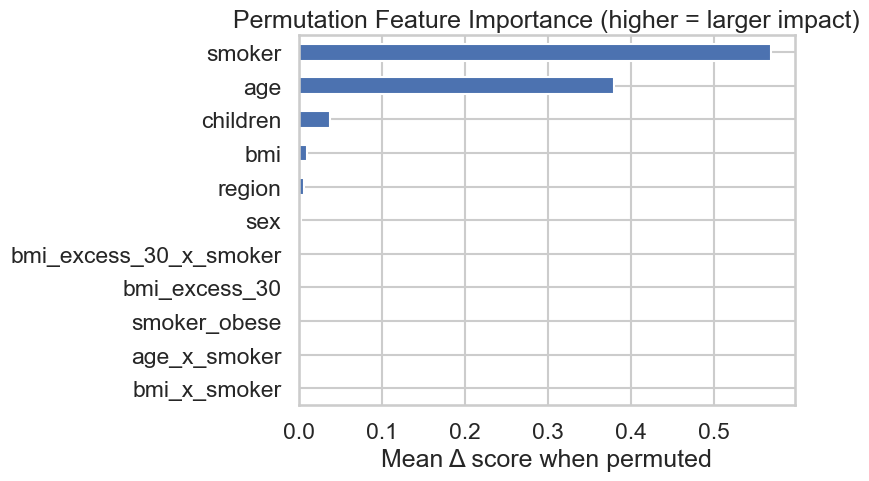

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pre: your ColumnTransformer from earlier
# lin: your LinearRegression/ElasticNet/etc.
pipe = make_pipeline(pre, lin)
pipe.fit(X_train, y_train)

# use a regression-friendly score (higher is better). For MSE, invert the sign.
neg_rmse = make_scorer(lambda yt, yp: -np.sqrt(mean_squared_error(yt, yp)))

result = permutation_importance(
    pipe,
    X_test,             # raw DF with original columns
    y_test,
    n_repeats=10,
    random_state=42,
    scoring=neg_rmse,   # or leave default R^2
)

imp = pd.Series(result.importances_mean, index=X_test.columns).sort_values()
imp.plot.barh()
plt.title("Permutation Feature Importance (higher = larger impact)")
plt.xlabel("Mean Δ score when permuted")
plt.show()


# SHAP Values

In [ ]:
import shap
explainer = shap.Explainer(lin, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

NameError: name 'lin' is not defined